In [147]:
#from supportFunctions import *
import cPickle as pickle
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sn
import pandas as pd 

import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
from sklearn.metrics import confusion_matrix,classification_report



In [32]:
def extractFeatures(imageDict, dist = 5):
    n = imageDict['numPointsInBox']
    y = np.zeros(n)
    
    v1,v2,h1,h2 = imageDict['boxEdges']
    
    img = imageDict['image1bit']
    featuresList = []
    
    fingerSet = imageDict['allFingerPoints']

    c = 0 
    for i in range(h1,h2):
        for j in range(v1,v2):
            x_matrix  = img[i-dist-1:i+dist , j-dist-1: j+dist]
            xVec = x_matrix.ravel()
            featuresList.append(xVec)
            
            if max(np.sum([i , j] == fingerSet, axis = 1 )) == 2:
                y[c] = 1
            
            c = c + 1

    X = np.vstack((featuresList))
    return(X,y)
    

In [33]:
def extractExamplesFromList(imageList, dist = 5):
    allFeaturesList = []
    allTargetList = []

    for i, imageDict in enumerate(imageList):
        features, target = extractFeatures(imageDict, dist = dist)
        allFeaturesList.append(features)
        allTargetList.append(target)

    x = np.vstack((allFeaturesList))
    y = np.hstack((allTargetList))
    
    return x, y

In [34]:
def Reshape_to_yHatMatrix(testingExamples, yHat):
    number_of_images = len(testingExamples)
    
    image_sizes = []
    result = []
    c = 0 
    for i in range(number_of_images):
        dummy_idx = (testingExamples[i]['boxHeight'],testingExamples[i]['boxWidth'])
        image_sizes.append(dummy_idx)
        
        test_im = yHat[c:(c + dummy_idx[0]*dummy_idx[1])] 
        c = c + (dummy_idx[0] * dummy_idx[1])
        
        test_im_matrix = test_im.reshape((dummy_idx[0], dummy_idx[1]))
        result.append(test_im_matrix)
    
    return(result)

In [35]:
def remove_small_clusters(clusters, min_finger_pixel):
    unique = set(clusters)
    for c in unique:
        if sum(clusters == c) < min_finger_pixel:
            clusters = np.delete(clusters, np.where(clusters == c))
    return(clusters)

In [74]:
pickleFileName = 'fingerDataSet' + '.pickle'
pickleFile = open(pickleFileName, 'rb')
data = pickle.load(pickleFile)
pickleFile.close()

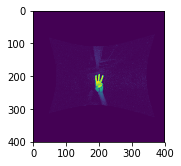

In [75]:
plt.imshow(data[51]['image'])
plt.show()

In [93]:
#Constructing Traning Data Set:
trainingExampleIndices = np.arange(0,45)
trainingExamples = [data[index] for index in trainingExampleIndices]
trainX, trainY = extractExamplesFromList(trainingExamples, dist = 4)

#Constructing Test Data Set:
testingExampleIndices = [46, 47, 48, 49, 50, 51, 52, 53]
testingExamples = [data[index] for index in testingExampleIndices]
testX, testY = extractExamplesFromList(testingExamples, dist = 4)


In [127]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5)
clf = clf.fit(trainX, trainY)
yHat = clf.predict(testX)

In [128]:
tn, fp, fn, tp = confusion_matrix(testY, yHat).ravel()
confusion_matrix(testY, yHat)


array([[18497,   116],
       [  681,  1169]])

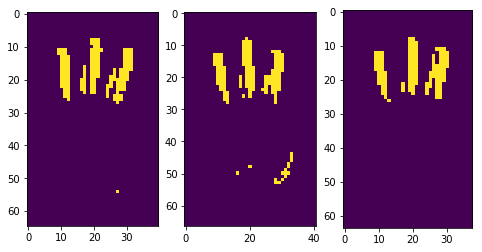

In [129]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, yHat)

fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()

In [80]:
X_i = np.where(Y_hat[1] == 1)[0]
X_j = np.where(Y_hat[1] == 1)[1]

data_cl  = np.column_stack((X_i, X_j))
data_cl.shape

(167, 2)

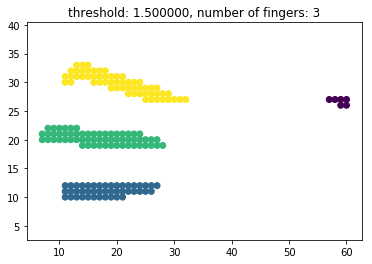

In [83]:
# clustering
thresh = 1.5
clusters = hcluster.fclusterdata(data_cl, thresh, criterion="distance")
#removing small clusters (caused by false positives)
new_clusters = remove_small_clusters(clusters,15)

# plotting
plt.scatter(*np.transpose(data_cl), c=clusters)
plt.axis("equal")
title = "threshold: %f, number of fingers: %d" % (thresh, len(set(new_clusters)))
plt.title(title)
plt.show()


In [132]:
def plots_estimates_and_actuals(testingExampleIndices,yHat, testY, data):
    """
    For given yHat(estimated), testY(actual), and test examples,
    it visualizes these in subplots.
    
    yHat and testY should be vectors 
    
    """
    fig = plt.figure(0, (8, 6))
    Y_hat = Reshape_to_yHatMatrix(testingExamples, yHat)
    Y_test = Reshape_to_yHatMatrix(testingExamples, testY)
    for i in range(len(testingExampleIndices)):
        
        fig.add_subplot(1,len(testingExampleIndices),i+1)
        imageDict = data[testingExampleIndices[i]]
        #im = makeGrayScale(imageDict)
        im = imageDict['croppedImage']
        im2 = im.copy()

        #Paint with matches:
        im[Y_test[i]==1] = [90]
        im2[Y_hat[i]==1] = 0
        
        
        
        plt.imshow(im2, interpolation = 'none')
        plt.imshow(im, interpolation = 'none', alpha = 0.3)
    plt.show()

In [154]:
def plot_confusion_matrix(testY, yHat, is_normalized = True):
    if is_normalized == True : 
        normalized_confusion_matrix = confusion_matrix(testY, yHat)/confusion_matrix(testY, yHat).sum()
        df_confusion_normalized = pd.DataFrame(normalized_confusion_matrix, index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])

        plt.figure(figsize = (9,6))
        sn.set(font_scale=2)
        sn.heatmap(df_confusion_normalized, annot = True, fmt='.4g')
        plt.show()
    else:
        df_confusion = pd.DataFrame(confusion_matrix(testY, yHat), index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])
        plt.figure(figsize = (9,6))
        sn.set(font_scale=2)
        sn.heatmap(df_confusion, annot = True, fmt='.4g')
        plt.show()
        
    

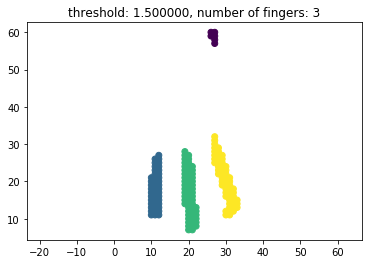

In [89]:
plt.scatter(np.array(data_cl)[:,1], np.array(data_cl)[:,0] , c=clusters)
plt.axis("equal")
title = "threshold: %f, number of fingers: %d" % (thresh, len(set(new_clusters)))
plt.title(title)
plt.show()



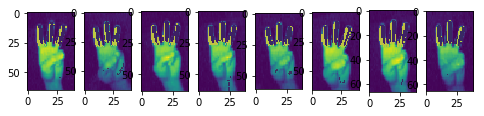

In [133]:
plots_estimates_and_actuals(testingExampleIndices,yHat, testY, data)

In [ ]:
metric

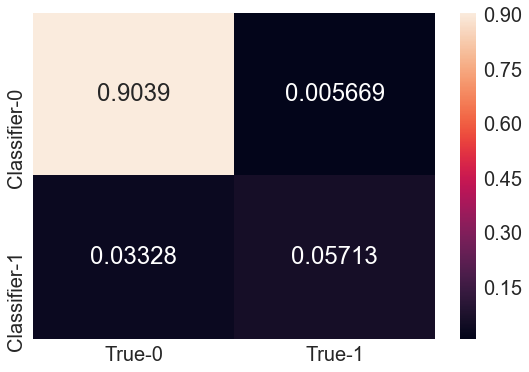

In [155]:
plot_confusion_matrix(testY, yHat, is_normalized = True)

In [135]:
from sklearn.linear_model import LogisticRegression

In [136]:
classifier = LogisticRegression(random_state=0)
classifier.fit (trainX, trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [137]:
y_hat_logi = classifier.predict(testX)

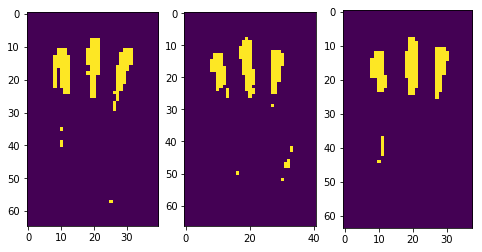

In [138]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_logi)

fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()

In [139]:
from sklearn.ensemble import RandomForestClassifier

In [140]:
classifier_RF = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state= 0)
classifier_RF.fit(trainX, trainY)
y_hat_RF = classifier_RF.predict(testX)

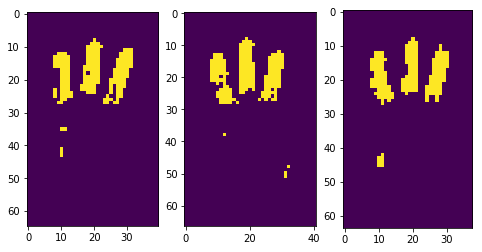

In [141]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_RF)

fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()

In [142]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(54, 27, 3))
mlp.fit(trainX , trainY)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(54, 27, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [143]:
y_hat_ANN = mlp.predict(testX)


confusion_matrix(testY, y_hat_ANN)



array([[18505,   108],
       [  242,  1608]])

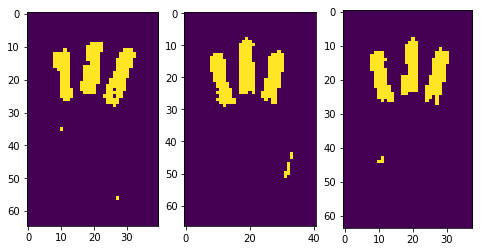

In [144]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_ANN)

fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()